<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/GraphNeuralNetworks/Part2_HandlingData_KarateClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.13


In [2]:
!python -c "import torch; print(torch.version.cuda)"

11.3


In [3]:
# PyTorch version
!python -c "import torch; print(torch.__version__)"

1.11.0+cu113


In [4]:
# Install required packages.
#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install torch-geometric


Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 2.5 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 2.0 MB/s 
     |████████████████████████████████| 407 kB 11.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=34c39b025b1f9a3021d3ef91e0980dcf93c6ee6b878332f01d9b3b8b0d01442b
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [5]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
from torch_geometric.datasets import KarateClub

In [7]:
dataset = KarateClub()

In [8]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of Node Features: {dataset.num_node_features}')
print(f'Number of Edge Features: {dataset.num_edge_features}')


Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Number of Node Features: 34
Number of Edge Features: 0


# **Karate Club Dataset Info:**
- This dataset holds exactly one graph, 
- Each node in this dataset is assigned a 34-dimensional feature vector (which uniquely describes the members of the karate club). 
- The graph holds exactly 4 classes, which represent the community each node belongs to.

# **Dataset <-> data**
Each graph in PyTorch Geometric is represented by a single Data object, which holds all the information to describe its graph representation.


https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
- data.x: Node feature matrix with shape [num_nodes, num_node_features]
- data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
- data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
- data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
- data.pos: Node position matrix with shape [num_nodes, num_dimensions]

In [9]:
data = dataset[0]  # Get the first graph object.

print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


Above we can see that this data object holds 4 attributes: 
- (1) The edge_index property holds the information about the graph connectivity, i.e., a tuple of source and destination node indices for each edge. 
- (2) node features as x (each of the 34 nodes is assigned a 34-dim feature vector)
- (3) node labels as y (each node is assigned to exactly one class). 

In [10]:
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is Directed: {data.is_directed()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Has isolated nodes: False
Has self-loops: False
Is Directed: False
Is undirected: True


In [11]:
print(f'Edge weight: {data.edge_weight}')
print(f'Graph contains isolated nodes: {data.contains_isolated_nodes()}')

Edge weight: None
Graph contains isolated nodes: False


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)


In [12]:
print('==============================================================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')


Number of training nodes: 4
Training node label rate: 0.12


# **Node Store**

In [13]:
print(data)
data.node_stores

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


[{'x': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]), 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
    

In [14]:
data.to_dict()

{'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
         [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
           3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
           1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
           2,  3,  0,  2,

In [15]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

<IPython.core.display.Javascript object>

Karate Club dataset:
- edge_index=[2, 156]

In [16]:
edge_index = data.edge_index

This representation is known as the COO format (coordinate format) commonly used for representing sparse matrices. 

In [18]:
# Print as tensor
print(edge_index.t())

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [17]:
edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

# **Graph Classes**

In [19]:
print(f'Number of classes: {dataset.num_classes}')
print(data)

Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [20]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [21]:
data.y.shape

torch.Size([34])

## **Node Features**

In [22]:
print(data.num_node_features)
print(data.num_features)
print(data.num_nodes)

34
34
34


https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html
- data.x: Node feature matrix with shape [num_nodes, num_node_features]

In [23]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [24]:
data.x[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
# data.x[34] will be out of the range
data.x[33] # all 0 to 33 features

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

# **Graph Visualization**

In [26]:
def visualize_graph(G, color):
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

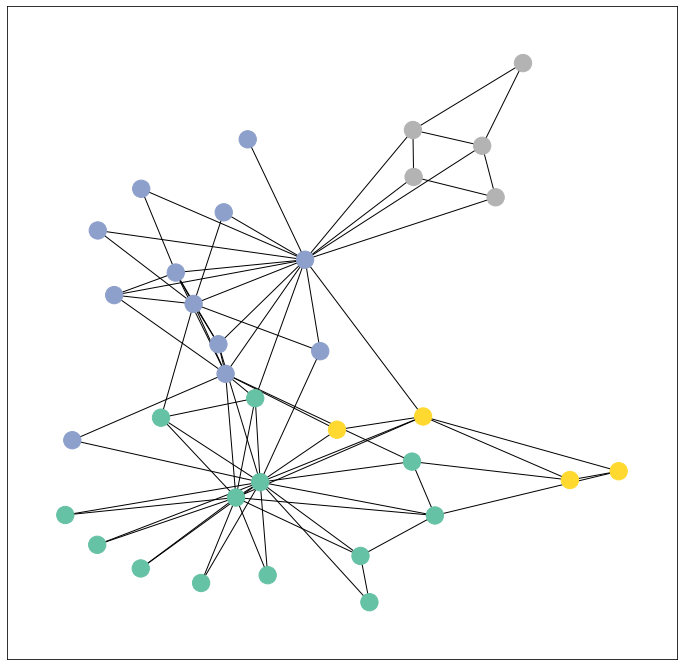

In [29]:
from torch_geometric.utils import to_networkx
karate_undirected_graph = to_networkx(data, to_undirected=True)
visualize_graph(karate_undirected_graph, color=data.y)

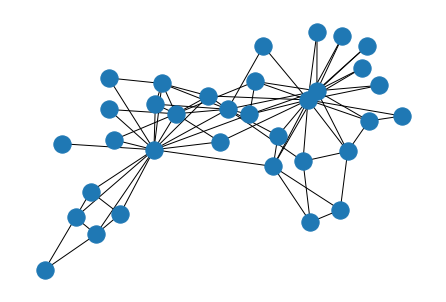

In [36]:
nx.draw(to_networkx(data, to_undirected=True))

In [37]:
karate_undirected_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

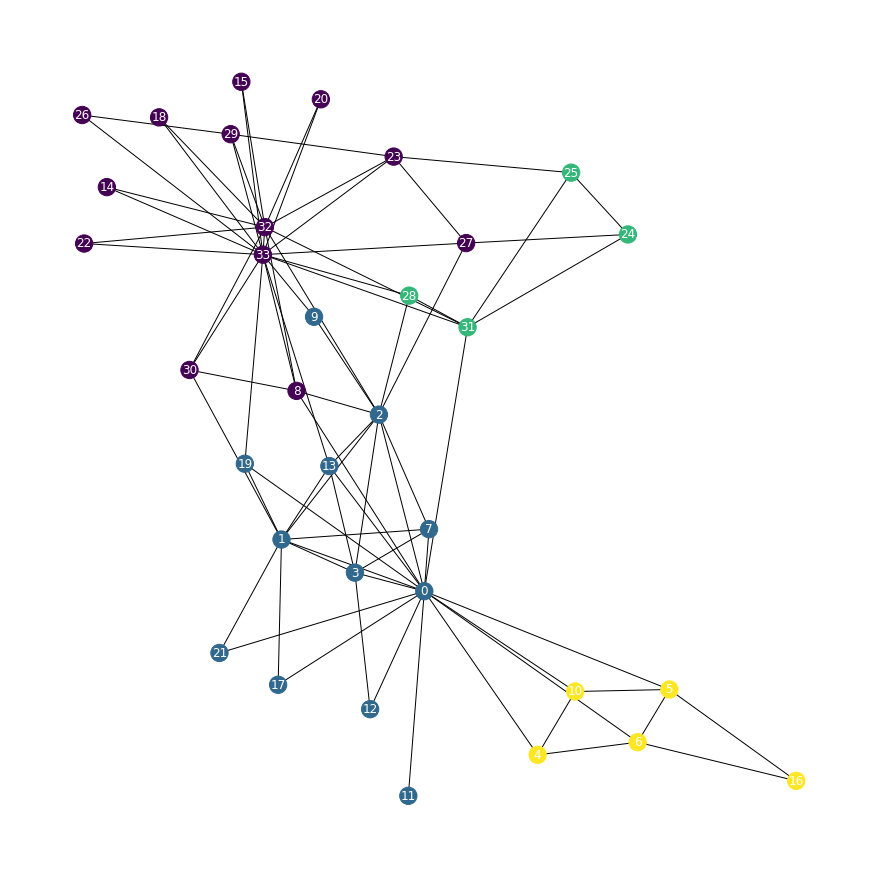

In [38]:
plt.figure(figsize=(12,12))
nx.draw(karate_undirected_graph, cmap=plt.get_cmap('viridis'), with_labels=True, node_color=data.y, font_color='white')
# 4 Classes are visible

In [39]:
print(karate_undirected_graph.number_of_edges())
karate_undirected_graph.edges

78


EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

In [40]:
print(karate_undirected_graph.number_of_nodes())
karate_undirected_graph.degree
# Please check the undirected graph and make sure if you can match the degrees for node "0"

34


DegreeView({0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17})

In [43]:
karate_directed_graph = to_networkx(data)

In [44]:
karate_directed_graph.node

AttributeError: ignored

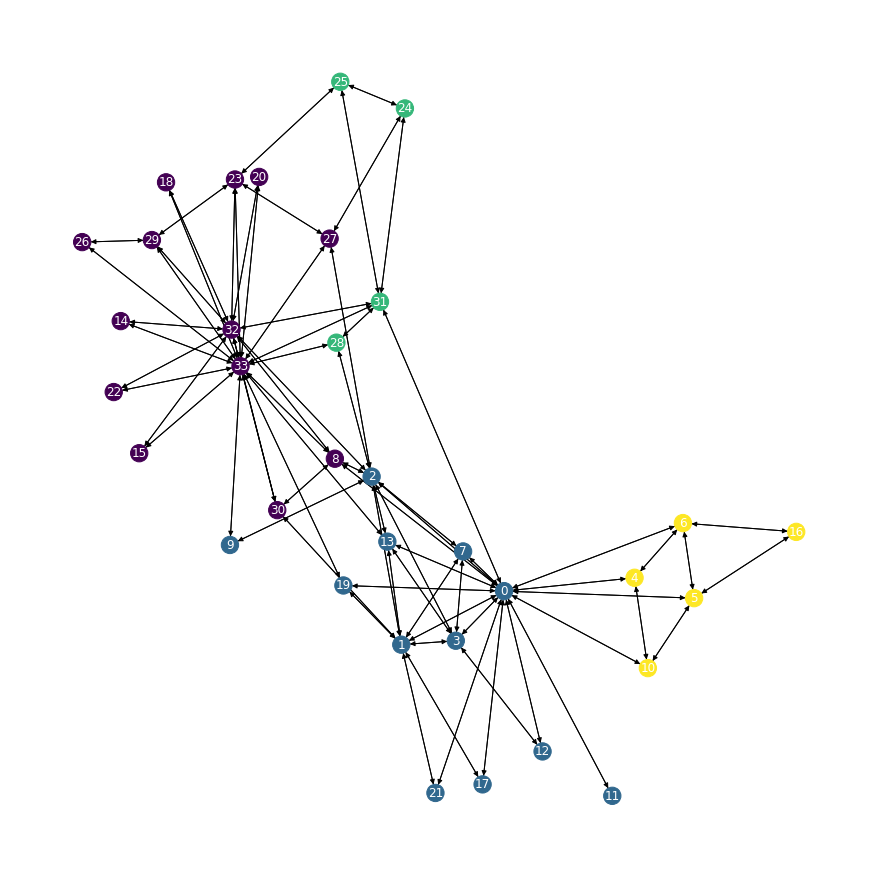

In [45]:
plt.figure(figsize=(12,12))
nx.draw(karate_directed_graph, cmap=plt.get_cmap('viridis'), with_labels=True, node_color=data.y, font_color='white')
# 4 Classes are visible
#nx.draw(karate_directed_graph, cmap=plt.get_cmap('viridis'), node_color=karate_directed_graph)

## **Edges**

In [47]:
print(karate_directed_graph.number_of_edges())
karate_directed_graph.edges

156


OutEdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 0), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 0), (2, 1), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 0), (3, 1), (3, 2), (3, 7), (3, 12), (3, 13), (4, 0), (4, 6), (4, 10), (5, 0), (5, 6), (5, 10), (5, 16), (6, 0), (6, 4), (6, 5), (6, 16), (7, 0), (7, 1), (7, 2), (7, 3), (8, 0), (8, 2), (8, 30), (8, 32), (8, 33), (9, 2), (9, 33), (10, 0), (10, 4), (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2), (13, 3), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (16, 5), (16, 6), (17, 0), (17, 1), (18, 32), (18, 33), (19, 0), (19, 1), (19, 33), (20, 32), (20, 33), (21, 0), (21, 1), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 23), (25, 24), (25, 31), (26, 29), (26, 33), (27, 2), (27, 23), (27, 24), (27, 33), (28, 

# **Node Degrees**

In [48]:
print(karate_directed_graph.number_of_nodes())
karate_directed_graph.degree
# Please check the directed graph and make sure if you can match the degrees for node "0"

34


DiDegreeView({0: 32, 1: 18, 2: 20, 3: 12, 4: 6, 5: 8, 6: 8, 7: 8, 8: 10, 9: 4, 10: 6, 11: 2, 12: 4, 13: 10, 14: 4, 15: 4, 16: 4, 17: 4, 18: 4, 19: 6, 20: 4, 21: 4, 22: 4, 23: 10, 24: 6, 25: 6, 26: 4, 27: 8, 28: 6, 29: 8, 30: 8, 31: 12, 32: 24, 33: 34})

In [49]:
nx.to_numpy_matrix(karate_directed_graph)

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

In [50]:
nx.to_numpy_matrix(karate_undirected_graph)

matrix([[0., 1., 1., ..., 1., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 1., 0.],
        ...,
        [1., 0., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 1., 0., 1.],
        [0., 0., 0., ..., 1., 1., 0.]])

# **Directed and Undirected Graph handling in PyG**

PyG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in edge_index